In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
import shap
warnings.filterwarnings("ignore") 

In [2]:
data = pd.read_csv(r'train.csv')
test = pd.read_csv(r'test.csv')
data.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [3]:
print("Missing values per column:")
print(data.isnull().sum())

Missing values per column:
id                            0
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64


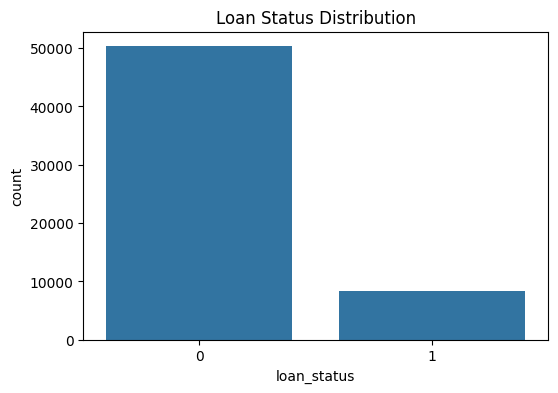

In [4]:
plt.figure(figsize = (6,4))

sns.countplot(x = 'loan_status', data = data)
plt.title('Loan Status Distribution')
plt.show()

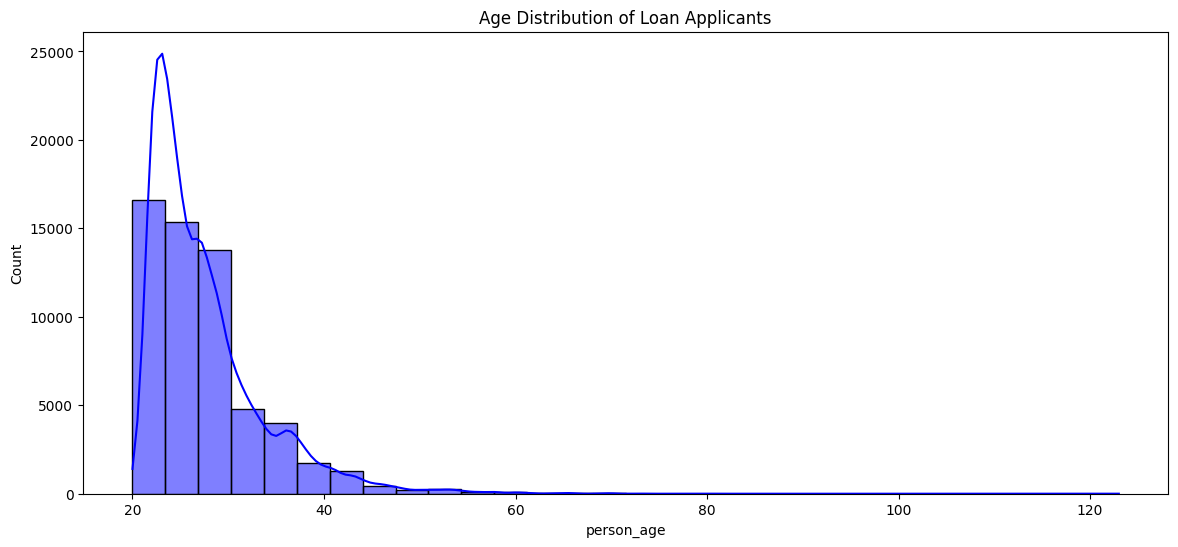

In [5]:
plt.figure(figsize = (14, 6))
sns.histplot(data['person_age'], kde = True, bins = 30, color = 'Blue', label = 'Person Age')
plt.title('Age Distribution of Loan Applicants')
plt.show()

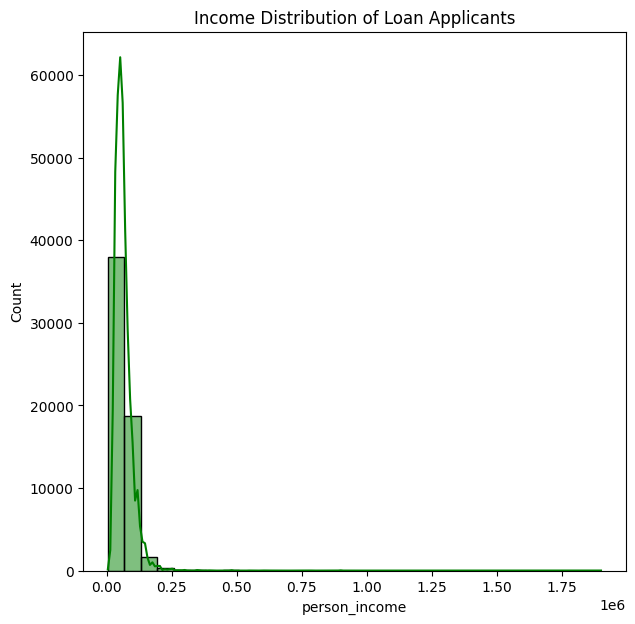

In [6]:
plt.figure(figsize=(7, 7))
sns.histplot(data['person_income'], kde=True, bins=30, color='green', label='Person Income')
plt.title('Income Distribution of Loan Applicants')
plt.show()

In [7]:
data = data.dropna()

In [8]:
# Encode categorical variables
# Label encoding for binary categorical variables 
label_enc = LabelEncoder()
data['cb_person_default_on_file'] = label_enc.fit_transform(data['cb_person_default_on_file'])

In [9]:
# One-hot encoding for other categorical variables
data = pd.get_dummies(data, columns=['person_home_ownership', 'loan_intent', 'loan_grade'], drop_first=True)

# Feature Scaling 
scaler = StandardScaler()
numeric_features = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
data[numeric_features] = scaler.fit_transform(data[numeric_features])

In [10]:
# Splitting data into features (X) and target (y)
X = data.drop(['loan_status', 'id'], axis=1)  # Drop the target variable and id
y = data['loan_status']

In [11]:
# Splitting the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Display the shapes of the training and test sets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (46916, 22), y_train shape: (46916,)
X_test shape: (11729, 22), y_test shape: (11729,)


In [13]:
# Model Training and Ensemble
# Initialize a list to store individual models
models = []

# Logistic Regression
lr_model = LogisticRegression(max_iter=1000)  
lr_model.fit(X_train, y_train)
models.append(('Logistic Regression', lr_model))

# Random Forest Classifier
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
models.append(('Random Forest', rf_model))

In [14]:
# Ensemble Predictions
ensemble_predictions = np.zeros(X_test.shape[0])

# Apply each model and weight their probabilities
for name, model in models:
    predictions = model.predict_proba(X_test)[:, 1]  
    ensemble_predictions += predictions

# Normalize the predictions by dividing by the number of models
ensemble_predictions /= len(models)

# Convert probabilities to class labels (0 or 1) based on a threshold (e.g., 0.5)
ensemble_predictions_labels = (ensemble_predictions > 0.5).astype(int)


In [15]:
# Evaluate the ensemble performance
accuracy = accuracy_score(y_test, ensemble_predictions_labels)
roc_auc = roc_auc_score(y_test, ensemble_predictions)
print(f"Ensemble Accuracy: {accuracy}")
print(f"ROC AUC Score: {roc_auc}")
print(classification_report(y_test, ensemble_predictions_labels))

Ensemble Accuracy: 0.9456049109045954
ROC AUC Score: 0.9351091907228066
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     10087
           1       0.89      0.70      0.78      1642

    accuracy                           0.95     11729
   macro avg       0.92      0.84      0.88     11729
weighted avg       0.94      0.95      0.94     11729



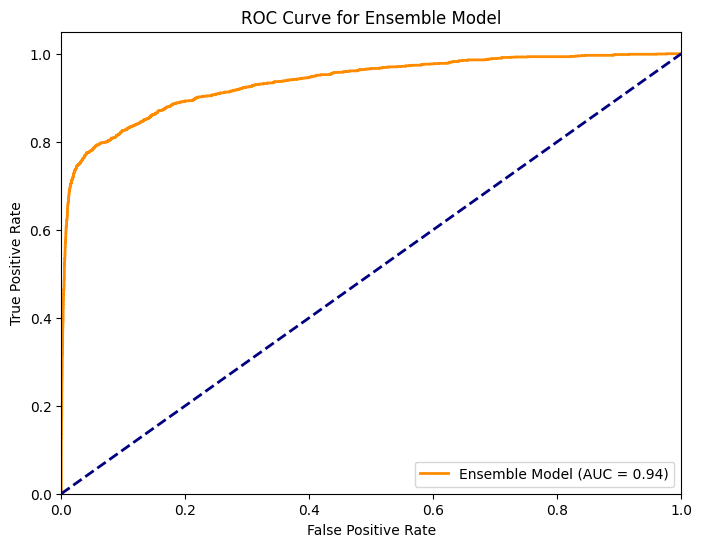

In [16]:
# Visualizing ROC Curve for the Ensemble Model
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, ensemble_predictions)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Ensemble Model (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Ensemble Model')
plt.legend(loc="lower right")
plt.show()

In [17]:
# Encode categorical variables for the test data
test['cb_person_default_on_file'] = label_enc.transform(test['cb_person_default_on_file'])

# Apply one-hot encoding on test data 
test_data = pd.get_dummies(test, columns=['person_home_ownership', 'loan_intent', 'loan_grade'], drop_first=True)

# Ensure that both the training and test datasets have the same columns
missing_cols = set(X.columns) - set(test_data.columns)
for col in missing_cols:
    test_data[col] = 0  

In [18]:
test_data = test_data[X.columns]

# Feature Scaling for test data 
test_data[numeric_features] = scaler.transform(test_data[numeric_features])

# Make predictions on the test set using the ensemble model
ensemble_test_predictions = np.zeros(test_data.shape[0])
for name, model in models:
    test_preds = model.predict_proba(test_data)[:, 1]
    ensemble_test_predictions += test_preds

In [19]:
# Normalize predictions
ensemble_test_predictions /= len(models)

# Convert predictions to binary labels based on a threshold
ensemble_test_labels = (ensemble_test_predictions > 0.5).astype(int)

# Prepare the submission file
submission = pd.DataFrame({'id': test_data.index, 'loan_status': ensemble_test_labels})
submission.to_csv('submission.csv', index=False)

print("Submission file saved!")

Submission file saved!


In [20]:
# Import necessary library for displaying results in a table
from tabulate import tabulate

# Collect the model performance metrics into a list of dictionaries
results = [
    {'Model': 'Logistic Regression', 
     'Accuracy': accuracy_score(y_test, lr_model.predict(X_test)),
     'ROC-AUC': roc_auc_score(y_test, lr_model.predict_proba(X_test)[:, 1])},
    
    {'Model': 'Random Forest', 
     'Accuracy': accuracy_score(y_test, rf_model.predict(X_test)),
     'ROC-AUC': roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])},
    
    {'Model': 'Ensemble (LR + RF)', 
     'Accuracy': accuracy,
     'ROC-AUC': roc_auc}
]

# Create a DataFrame for better display
results_df = pd.DataFrame(results)

# Display results as a table using tabulate
print(tabulate(results_df, headers='keys', tablefmt='grid'))

# Alternatively, you can directly display the DataFrame
results_df

+----+---------------------+------------+-----------+
|    | Model               |   Accuracy |   ROC-AUC |
+====+=====================+============+===========+
|  0 | Logistic Regression |   0.911416 |  0.904883 |
+----+---------------------+------------+-----------+
|  1 | Random Forest       |   0.951658 |  0.937781 |
+----+---------------------+------------+-----------+
|  2 | Ensemble (LR + RF)  |   0.945605 |  0.935109 |
+----+---------------------+------------+-----------+


,Model,Accuracy,ROC-AUC
0,Logistic Regression,0.911416,0.904883
1,Random Forest,0.951658,0.937781
2,Ensemble (LR + RF),0.945605,0.935109


In [21]:
print(submission)

          id  loan_status
0          0            1
1          1            0
2          2            1
3          3            0
4          4            0
...      ...          ...
39093  39093            0
39094  39094            0
39095  39095            0
39096  39096            1
39097  39097            1

[39098 rows x 2 columns]


In [23]:
# Prepare the submission file with predicted probabilities
submission = pd.DataFrame({'id': test_data.index, 'loan_status': ensemble_test_predictions})
submission.to_csv('submission.csv', index=False)

In [25]:
# Load and inspect the updated submission file
submission_check = pd.read_csv('submission.csv')
print(submission_check.head())

   id  loan_status
0   0     0.859071
1   1     0.004849
2   2     0.641364
3   3     0.068437
4   4     0.279414


In [26]:
print(submission)

          id  loan_status
0          0     0.859071
1          1     0.004849
2          2     0.641364
3          3     0.068437
4          4     0.279414
...      ...          ...
39093  39093     0.036496
39094  39094     0.005042
39095  39095     0.029308
39096  39096     0.747702
39097  39097     0.860439

[39098 rows x 2 columns]


In [27]:
# Load the test dataset to check IDs
test_data = pd.read_csv('test.csv')
print(test_data[['id']].head())

      id
0  58645
1  58646
2  58647
3  58648
4  58649


In [28]:
# Prepare the submission file with predicted probabilities and correct IDs
submission = pd.DataFrame({'id': test_data['id'], 'loan_status': ensemble_test_predictions})
submission.to_csv('submission.csv', index=False)

In [31]:
# Load and inspect the updated submission file
submission_check = pd.read_csv('submission.csv')
print(submission_check.head())

      id  loan_status
0  58645     0.859071
1  58646     0.004849
2  58647     0.641364
3  58648     0.068437
4  58649     0.279414
